# IEEE-CIS Fraud Detection Kaggle competition
###### Solução - Endrew Rossin - Parte 2 ( Modelagem ).

Para ver uma descrição sobre a competição e a parte de análise exploratória dos dados, veja a Parte 1 deste trabalho: https://github.com/rossinendrew/Portfolio/blob/master/IEEE-EDA.ipynb

Neste Notebook utilizei os valores de Rounds, de divisoes do K-Fold e de taxa de aprendizado menores para que ele possa ser rodado mais rápido nesta demonstração. 

Na competição foi utilizado:

Para a validação os valores de K=5, learning rate = 0.01, sem rounds máximos, com early stopping rounds = 100.

Para a previsão final utilizei K=7, learning rate = 0.005, sem rounds máximos, com early stopping rounds = 100.

Para iniciar este desafio, inicialmente começo importando bibliotecas que utilizarei para fazer a feature engineering, a validação e a modelagem. Também defino um estado aleatório para manter os resultados consistentes e reproduzíveis.

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

import random, datetime

SEED = 99
random.seed(SEED)
np.random.seed(SEED)

pd.set_option('display.max_columns', None)

Faço o load dos dados e depois crio os dataframes de treino e o teste junto os dataframes disponibilizados pela coluna TransactionID.

In [2]:
dftrain_i = pd.read_csv('train_identity.csv')
dftrain_t = pd.read_csv('train_transaction.csv')
dftest_i = pd.read_csv('test_identity.csv')
dftest_t = pd.read_csv('test_transaction.csv')

In [3]:
dftrain = pd.merge(dftrain_i,dftrain_t,on='TransactionID',how='outer')
dftest = pd.merge(dftest_i,dftest_t,on='TransactionID',how='outer')
del dftrain_i, dftrain_t, dftest_i, dftest_t

# Feature Engineering

Assim como visto na fase exploratória, eu defino a data inicial dos dados como sendo em 1 de dezembro de 2017.

In [4]:
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')

Guardo a coluna de ID para ser enviada no arquivo de submissão.

In [5]:
solution = pd.DataFrame()
solution['TransactionID'] = dftest.TransactionID

Criei um dataframe para fazer o feature engineering simultaneamente nos dados de treino e nos dados de teste o que gerou uma melhora nos resultados. No caso da competição do Kaggle isto é eficiente para conseguir o score final ligeiramente maior, porém numa implementação real, isto pode acarretar em um grande custo computacional em comparação a melhora do modelo, uma vez que para se manter essa melhora ao longo do tempo, o modelo tem de ser treinado sempre que houver a necessidade de previsão para novos dados.

In [6]:
dffe = pd.concat([dftrain,dftest], axis =0, ignore_index=True )
print('Shape do dataframe de treino e teste total :',dffe.shape)

Shape do dataframe de treino e teste total : (1097231, 434)


Defini uma feature com o Datetime de cada transação. A partir dessa feature, criei outras features que se mostraram relevantes para o modelo como dia do ano, mês, hora, dia da semana e semana do ano.

In [7]:
dffe['DT_F'] = dffe['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
dffe['DT_DY'] = dffe['DT_F'].dt.dayofyear.astype(np.int)
dffe['DT_MO'] = dffe['DT_F'].dt.month
dffe['DT_H'] = dffe['DT_F'].dt.hour
dffe['DT_WD'] = dffe['DT_F'].dt.dayofweek
dffe['DT_WY'] = dffe['DT_F'].dt.weekofyear

Para criar o sistema de validação, eu considerei o mesmo padrão de divisão entre treino e teste.

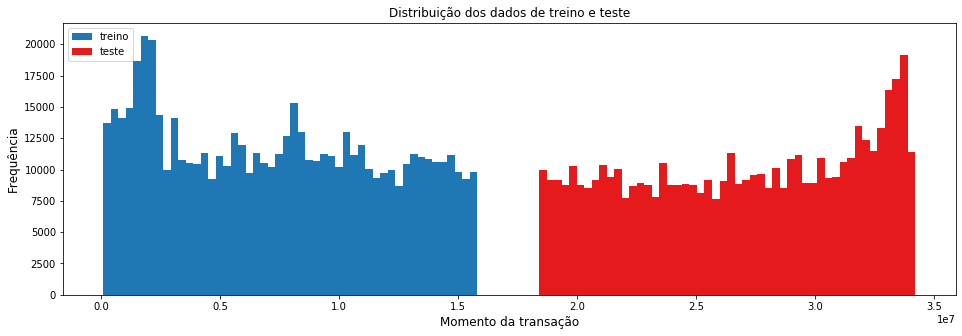

In [8]:
dftrain['TransactionDT'].plot(kind='hist',
                            figsize=(16, 5),
                            label='treino',
                            bins=50,
                            title='Distribuição dos dados de treino e teste',
                            colormap='tab10')
dftest['TransactionDT'].plot(kind='hist',
                           label='teste',
                           colormap='Set1',
                           bins=50)
plt.legend(loc='upper center')
plt.xlabel('Momento da transação', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.legend()
plt.show()

Dividi os dados de treino, em treino e teste de validação usando o método de holdout. O treino de validação são os primeiros meses dos dados de treino e o teste de validação são os últimos meses dos dados de treino. Mantendo a proporção do intervalo sem informação entre os dois.

In [9]:
val_train = dffe[:dftrain.shape[0]][(dffe['DT_DY'] >= 300) | (dffe['DT_DY'] < 53)]
val_test  = dffe[:dftrain.shape[0]][(dffe['DT_DY'] >= 69) & (dffe['DT_DY'] < 300)]
vafe = pd.concat([val_train,val_test], axis =0, ignore_index=True )
print('Shape do dataframe de validação total :',vafe.shape)

Shape do dataframe de validação total : (534069, 440)


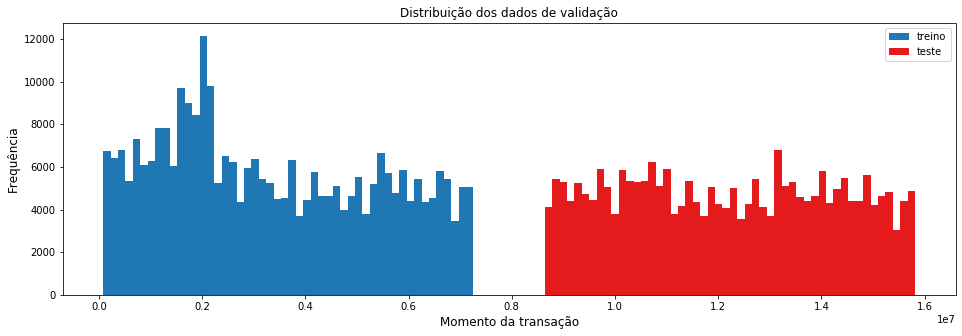

In [10]:
val_train['TransactionDT'].plot(kind='hist',
                            figsize=(16, 5),
                            label='treino',
                            bins=50,
                            title='Distribuição dos dados de validação',
                            colormap='tab10')
val_test['TransactionDT'].plot(kind='hist',
                           label='teste',
                           colormap='Set1',
                           bins=50)
plt.legend(loc='upper center')
plt.xlabel('Momento da transação', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.legend()
plt.show()

###### A seguir foram geradas novas features e as existentes foram tratadas nos dados de treino e de validação. Inicialmente eu construí o código até a validação e rodei sem nenhuma feature nova, então eu tive um baseline de quão bom era o modelo, a partir deste baseline sempre que eu adicionei uma nova feature eu rodei o código até o fim da validação e comparei se o modelo havia melhorado ou piorado em relação a score anterior.

Criei uma feature que separa os centavos do valor total da transação. O valor dos dólares não foi eficiente para melhorar o modelo, apenas os centavos.

In [11]:
for data in [dffe,vafe]:
    data['cents'] = np.round( data['TransactionAmt'] - np.floor(data['TransactionAmt']),2 )

Esta feature usa a coluna de informação do dispositivo, pega cada valor e primeiro cria uma coluna com a porcentagem de fraude de cada dispositivo, e também cria outra coluna com a contagem que cada dispositivo aparece no dataset.

In [12]:
for data in [dffe,vafe]:
    data['DeviceInfo_Percent'] = data['DeviceInfo'].map(data.groupby('DeviceInfo')['isFraud'].mean().round(2).to_dict())
    data['DeviceInfo_counts'] = data['DeviceInfo'].map(data['DeviceInfo'].value_counts().to_dict())

A próxima feature divide as colunas de e-mail do comprador e do recebedor. Criando 3 colunas, a primeira com a marca do e-mail, a segunda se é .com, .net ou outro, e a terceira coluna é o país do e-mail.

In [13]:
for data in [dffe,vafe]:
    data[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = data['P_emaildomain'].str.split('.', expand=True)
    data[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = data['R_emaildomain'].str.split('.', expand=True)

Esta feature cria id's com a junção das informações de cartões e endereços. Assim o modelo tem a informação para cada transação de que grupo de combinações dessas colunas aquela transação pertence.

In [14]:
for data in [dffe,vafe]:
    data['card1+card2'] = data.card1.map(str) +'_'+ data.card2.map(str)
    data['addr1+addr2'] = data.addr1.map(str) +'_'+ data.addr2.map(str)
    data['card1+addr1'] = data.card1.map(str) +'_'+ data.addr1.map(str)
    data['card1+addr2'] = data.card1.map(str) +'_'+ data.addr2.map(str)
    data['card2+addr1'] = data.card2.map(str) +'_'+ data.addr1.map(str)
    data['card2+addr2'] = data.card2.map(str) +'_'+ data.addr2.map(str)

Esta feature foi criada após eu analisar onde o modelo estava errando (demonstrado depois da validação), eu percebi que as colunas "M" tinham todas o valor máximo (2) em muitos casos onde a transação era fraudulenta. Fazendo a soma dessas colunas eu consegui criar uma variável categórica que representava a combinação de todas as variáveis "M" e também uma binária que ajuda o modelo a perceber quando todas as variáveis "M" tem o valor máximo (16). Esta feature deu uma grande melhora no modelo.

In [15]:
for data in [dffe,vafe]:
    data['MSum'] = data.M1 + data.M2 + data.M3 + data.M5 + data.M6 + data.M7 + data.M8 + data.M8
    data['MSum16'] = np.where((data.M1 + data.M2 + data.M3 + data.M5 + data.M6 + data.M7 + data.M8 + data.M8 == 16),1,0)

Adicionei uma feature com a contagem de quantas vezes cada valor de card1 apareceu.

In [16]:
for data in [dffe,vafe]:
    data['card1_count'] = data['card1'].map(data.groupby('card1')['TransactionDT'].count())

Realizei target encoding nas features categóricas que durante a análise exploratória verifiquei que suas classes tinham porcentagens bastante diferentes de fraude. Que foram o ProductCD e a M4.

In [17]:
for data in [dffe,vafe]:
    for col in ['ProductCD','M4']:
        temp_dict = data.groupby([col])['isFraud'].agg(['mean']).reset_index().rename(columns={'mean': col+'_target_mean'})
        temp_dict.index = temp_dict[col].values
        temp_dict = temp_dict[col+'_target_mean'].to_dict()

        data[col+'_target_mean'] = data[col].map(temp_dict)

Normalizei o valor das transações de acordo com a média da semana.

In [18]:
for data in [dffe,vafe]:
    data['trweek_mean'] = data['DT_WY'].map(data.groupby(['DT_WY'])['TransactionAmt'].agg(['mean']).to_dict()['mean'])
    data['trweek_std'] = data['DT_WY'].map(data.groupby(['DT_WY'])['TransactionAmt'].agg(['std']).to_dict()['std'])
    data['tramtnorm'] = (data['TransactionAmt'] - data['trweek_mean']) / dffe['trweek_std']

#### Encoding

Nas colunas que são objetos, preencho os valores nulos com a string "NaN" e realizo o label encoding. Depois transformo essas colunas para categóricas.

In [19]:
for data in [dffe,vafe]:
    for col in data.columns[data.dtypes == 'object']:
        data[col].fillna('NaN')
        data[col] = data[col].astype(str)
    
        le = LabelEncoder()
        le.fit(data[col])
        data[col] = le.transform(data[col])
        
        data[col] = data[col].astype('category')

# Divisão

Divido de volta os dataframes em treino, teste e validação holdout.

In [20]:
dftrain = dffe[:dftrain.shape[0]]
dftest  = dffe[dftrain.shape[0]:]
print('Shape treino: {:} | Shape teste: {:}'.format(dftrain.shape, dftest.shape))
val_train = vafe[:val_train.shape[0]]
val_test  = vafe[val_train.shape[0]:]
print('Shape validação treino: {:} | Shape validação teste: {:}'.format(val_train.shape, val_test.shape))

Shape treino: (590540, 463) | Shape teste: (506691, 463)
Shape validação treino: (294193, 463) | Shape validação teste: (239876, 463)


Removo algumas colunas que são puramente ruido e outras que não serão mais úteis. 

In [21]:
val_train.drop(['TransactionID','TransactionDT','DT_F','DT_DY'], axis=1, inplace = True)
val_test.drop(['TransactionID','TransactionDT','DT_F','DT_DY'], axis=1, inplace = True)
dftrain.drop(['TransactionID','TransactionDT','DT_F','DT_DY'], axis=1, inplace = True)
dftest.drop(['TransactionID','TransactionDT','DT_F','DT_DY','isFraud'], axis=1, inplace = True)

Divido os dados de validação holdout entre as variáveis preditivas e a variável predita.

In [22]:
val_trainX = val_train.drop('isFraud',axis=1)
val_trainy = val_train.isFraud
val_testX = val_test.drop('isFraud',axis=1)
val_testy = val_test.isFraud

# Validação

Decidi usar o LightGBM para criar o modelo pois é um modelo baseado em árvores, que para esse tipo de dados com alta dimensionalidade, algumas colunas com multicolinearidade, além da grande quantidade de valores nulos se mostra eficiente. Entre o LightGBM e o XGBoost eu decidi fazer a fase de validação com o LightGBM pois além de ser eficiente, é mais leve e roda mais rápido no meu computador.

Defini os parâmetros que serão utilizados para fazer a validação.

In [23]:
lgb_params = {
                    'objective':'binary',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.4,
                    'num_leaves': 256,
                    'max_depth':-1,
                    'colsample_bytree': 0.9,
                    'subsample_freq':1,
                    'subsample':0.9,
                    'n_estimators':100,
                    'verbose':-1,
                    'seed': SEED,
                    'early_stopping_rounds':100, 
             } 

Para fazer a validação eu uso o método de validação cruzada K-Fold estratificado devido ao grande desequilíbrio em dados com fraude e sem fraude.

Configuro o modelo para parar caso não melhore seu score durante os 100 próximos rounds usando como set de validação a fold de teste da iteração atual, guardo os valores de AUC para cada iteração.

Faço as previsões nos dados do holdout que eu tinha feito anteriormente durante cada iteração.

No final imprimo o valor médio de AUC da validação cruzada e também calculo o valor médio das previsões para os dados do holdout.

In [24]:
K = 3
folds = StratifiedKFold(K,shuffle= True, random_state = SEED)
testpred = np.zeros(val_testX.shape[0])
best_scorecv= 0

for fold , (train_index,test_index) in enumerate(folds.split(val_trainX, val_trainy)):
    print('Fold:',fold+1)
    
    X_traincv, X_testcv = val_trainX.iloc[train_index], val_trainX.iloc[test_index]
    y_traincv, y_testcv = val_trainy.iloc[train_index], val_trainy.iloc[test_index]
    
    train_data = lgb.Dataset(X_traincv, y_traincv)
    val_data   = lgb.Dataset(X_testcv, y_testcv)
    
    %time LGBM = lgb.train(lgb_params, train_data,valid_sets= val_data,verbose_eval=25)
    best_scorecv += LGBM.best_score['valid_0']['auc']
    testpred += LGBM.predict(val_testX)
    print()
    
best_scorecv /= K
print('AUC Mean:', best_scorecv)
testpred /= K

Fold: 1
Training until validation scores don't improve for 100 rounds.
[25]	valid_0's auc: 0.870791
[50]	valid_0's auc: 0.680593
[75]	valid_0's auc: 0.489668
[100]	valid_0's auc: 0.475079
Did not meet early stopping. Best iteration is:
[13]	valid_0's auc: 0.916676
Wall time: 1min 4s

Fold: 2
Training until validation scores don't improve for 100 rounds.
[25]	valid_0's auc: 0.837383
[50]	valid_0's auc: 0.650655
[75]	valid_0's auc: 0.633921
[100]	valid_0's auc: 0.613906
Did not meet early stopping. Best iteration is:
[12]	valid_0's auc: 0.903368
Wall time: 1min 3s

Fold: 3
Training until validation scores don't improve for 100 rounds.
[25]	valid_0's auc: 0.857767
[50]	valid_0's auc: 0.680222
[75]	valid_0's auc: 0.601707
[100]	valid_0's auc: 0.543523
Did not meet early stopping. Best iteration is:
[9]	valid_0's auc: 0.907573
Wall time: 1min 5s

AUC Mean: 0.9092059174710464


Imprimo a score final da validação do holdout.

In [25]:
private_scorecv = roc_auc_score(np.array(val_testy),np.array(testpred))
print('ROC AUC Score: ',private_scorecv)

ROC AUC Score:  0.8291531243482767


# Analise de erro

Nesta fase foram analisados diversas vezes os dados onde o modelo estava errando para criar novas features que poderiam ajudar na melhora do modelo. Criei um dataframe com as colunas da previsão e do valor real do target juntos para poderem ser visualizados melhor, e assim a seguir analisar e identificar padrões nas outras colunas.

In [26]:
modelerror = val_test.copy()

In [27]:
modelerror['prediction'] = testpred
modelerror['isfraud'] = modelerror.isFraud

Mostro apenas as linhas que foram previstas acima de 0.9 e que na verdade o target é 0. Foram feitas outras visualizações com valores diferentes da previsão e do target.

In [28]:
modelerror[(modelerror.prediction > 0.90) & (modelerror.isfraud == 0)].head(10)

,C1,C10,C11,C12,C13,C14,C2,C3,C4,C5,C6,C7,C8,C9,D1,D10,D11,D12,D13,D14,D15,D2,D3,D4,D5,D6,D7,D8,D9,DeviceInfo,DeviceType,M1,M2,M3,M4,M5,M6,M7,M8,M9,P_emaildomain,ProductCD,R_emaildomain,TransactionAmt,V1,V10,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V11,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V12,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V13,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V14,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V15,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V16,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V17,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V18,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V19,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V2,V20,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V21,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V22,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V23,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V24,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V25,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V26,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V27,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V28,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V29,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V3,V30,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V31,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V32,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V33,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,V34,V35,V36,V37,V38,V39,V4,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V5,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V6,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V7,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V8,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V9,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,addr1,addr2,card1,card2,card3,card4,card5,card6,dist1,dist2,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,isFraud,DT_MO,DT_H,DT_WD,DT_WY,cents,DeviceInfo_Percent,DeviceInfo_counts,P_emaildomain_1,P_emaildomain_2,P_emaildomain_3,R_emaildomain_1,R_emaildomain_2,R_emaildomain_3,card1+card2,addr1+addr2,card1+addr1,card1+addr2,card2+addr1,card2+addr2,MSum,MSum16,card1_count,ProductCD_target_mean,M4_target_mean,trweek_mean,trweek_std,tramtnorm,prediction,isfraud
294987,1242.0,443.0,978.0,0.0,710.0,663.0,1359.0,0.0,910.0,0.0,926.0,0.0,488.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.833332,0.833333,1707,2,2,2,2,3,2,2,2,2,2,16,2,1,400.000,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.0,NaN,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,4.0,NaN,5.0,18.0,0.0,0.0,2.0,9.0,1.0,0.0,13.0,5.0,NaN,16.0,0.0,16.0,7.0,0.0,4.0,1.0,44.0,2.0,13.0,NaN,1.0,1.0,22.0,12.0,1.0,8.0,1.0,2.0,14.0,1.0,NaN,NaN,2.0,15.0,0.000000,10925.000000,2525.000000,0.0000,0.0,375.000000,225.000000,3825.000000,NaN,1825.000000,0.000000,2300.000000,900.000000,0.0000,3650.0000,1250.0000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.0000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.0,NaN,0.000000,0.0,0.0,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.0000,NaN,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

# Feature Selection

Usei o retorno do LightGBM das variáveis mais importantes para o modelo para gerar um gráfico. Selecionei vários números diferentes de features e novamente apliquei a mesma validação cruzada para ser feita a comparação.

In [29]:
feature_imp = pd.DataFrame(sorted(zip(LGBM.feature_importance(),val_testX.columns)), 
                               columns=['Value','Feature'])

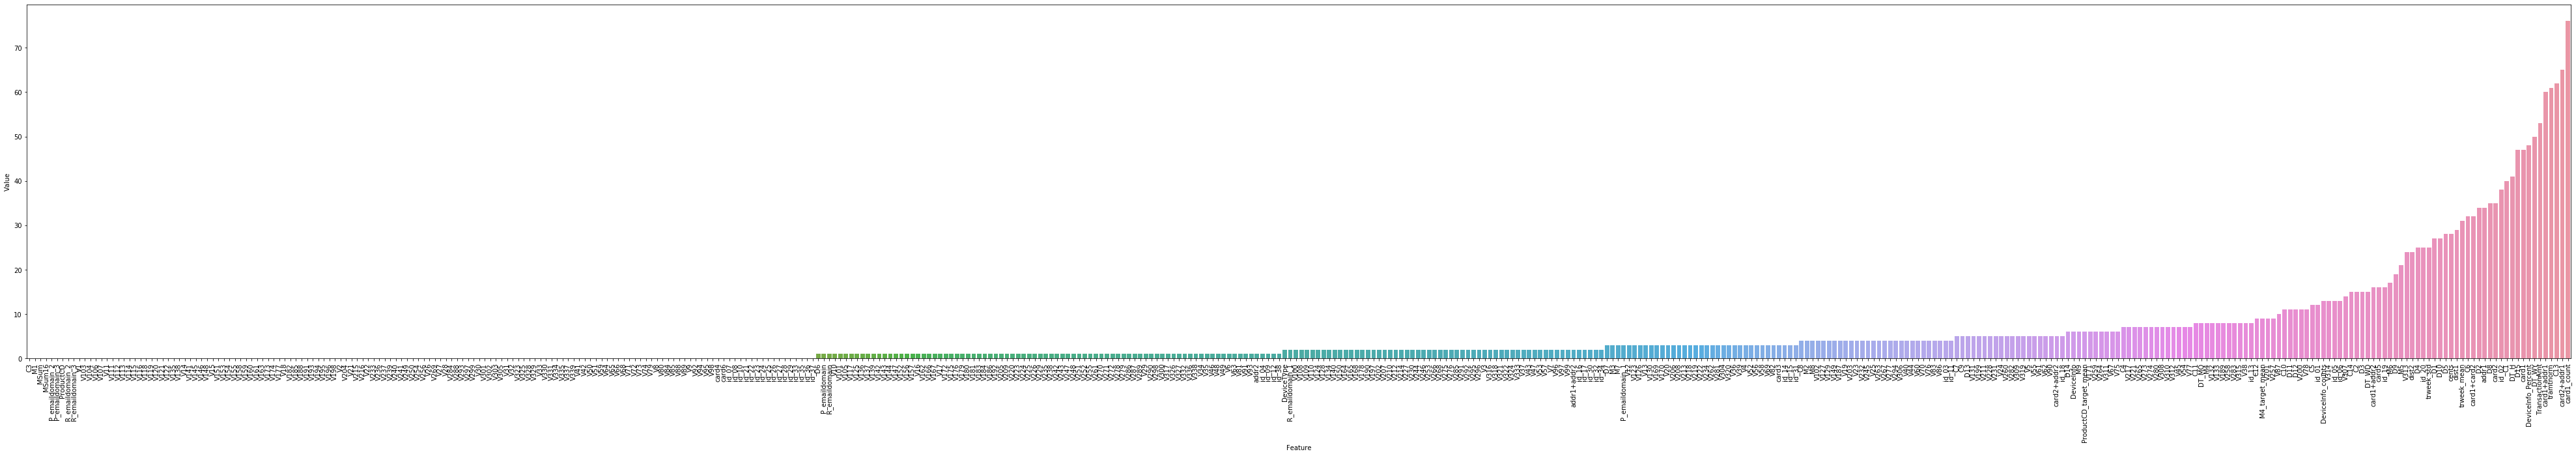

In [30]:
plt.figure(figsize=(70, 10))
plt.xticks(rotation=90)
sns.barplot(y=feature_imp.Value, x=feature_imp.Feature)

No gráfico é possível ver que uma pequena quantidade de colunas tem mais importância para o modelo. Então eu seleciono uma porcentagem das variáveis para criar um novo dataframe e refazer o processo de validação cruzada. Fiz os testes com 20% das variáveis, 40%, 60% e 80%. Mas em todos os testes usar 100% das variáveis fez com que o modelo tivesse um score maior. Então eu decidi deixar selecionadas para o modelo de previsão final 100% das features. 

In [31]:
Selected_Features = list(feature_imp[feature_imp.Value >= feature_imp.Value.quantile(0.0)].Feature)

In [32]:
val_train = val_train[Selected_Features + ['isFraud']]
val_test  = val_test[Selected_Features + ['isFraud']]
print('Shape validação treino: {:} | Shape validação teste: {:}'.format(val_train.shape, val_test.shape))

Shape validação treino: (294193, 459) | Shape validação teste: (239876, 459)


In [33]:
val_trainX = val_train.drop('isFraud',axis=1)
val_trainy = val_train.isFraud
val_testX = val_test.drop('isFraud',axis=1)
val_testy = val_test.isFraud

In [34]:
K = 3
folds = StratifiedKFold(K,shuffle= True, random_state = SEED)
testpred = np.zeros(val_testX.shape[0])
best_scorecv= 0
for fold , (train_index,test_index) in enumerate(folds.split(val_trainX, val_trainy)):
    print('Fold:',fold+1)
    
    X_traincv, X_testcv = val_trainX.iloc[train_index], val_trainX.iloc[test_index]
    y_traincv, y_testcv = val_trainy.iloc[train_index], val_trainy.iloc[test_index]
    
    train_data = lgb.Dataset(X_traincv, y_traincv)
    val_data   = lgb.Dataset(X_testcv, y_testcv)
    
    %time LGBM = lgb.train(lgb_params, train_data,valid_sets= val_data,verbose_eval=25)
    best_scorecv += LGBM.best_score['valid_0']['auc']
    testpred += LGBM.predict(val_testX)
    print()
best_scorecv /= K
print('AUC Mean:', best_scorecv)
testpred /= K

Fold: 1
Training until validation scores don't improve for 100 rounds.
[25]	valid_0's auc: 0.844597
[50]	valid_0's auc: 0.716997
[75]	valid_0's auc: 0.548604
[100]	valid_0's auc: 0.569293
Did not meet early stopping. Best iteration is:
[11]	valid_0's auc: 0.912035
Wall time: 1min 3s

Fold: 2
Training until validation scores don't improve for 100 rounds.
[25]	valid_0's auc: 0.847392
[50]	valid_0's auc: 0.633516
[75]	valid_0's auc: 0.641653
[100]	valid_0's auc: 0.435703
Did not meet early stopping. Best iteration is:
[7]	valid_0's auc: 0.905765
Wall time: 1min 2s

Fold: 3
Training until validation scores don't improve for 100 rounds.
[25]	valid_0's auc: 0.840812
[50]	valid_0's auc: 0.730556
[75]	valid_0's auc: 0.646321
[100]	valid_0's auc: 0.467651
Did not meet early stopping. Best iteration is:
[9]	valid_0's auc: 0.908647
Wall time: 1min 2s

AUC Mean: 0.9088155625466001


Imprimo o score para os modelos com e sem feature selection. (Esta parte foi refeita 4 vezes para poder tirar os scores para todas as porcentagens e chegar nos resultados citados anteriormente).

In [35]:
print('Score com feature selection: ',roc_auc_score(np.array(val_testy),np.array(testpred)),'|','Score: ',private_scorecv)

Score com feature selection:  0.830605443468406 | Score:  0.8291531243482767


# Submissão final

Defino os parâmetros que serão usados para fazer a previsão final.

In [36]:
lgb_params = {
                    'objective':'binary',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.4,
                    'num_leaves': 2**8,
                    'max_depth':-1,
                    'colsample_bytree': 0.9,
                    'subsample_freq':1,
                    'subsample':0.9,
                    'n_estimators':100,
                    'verbose':-1,
                    'seed': SEED,
                    'early_stopping_rounds':100, 
             } 

In [37]:
dftrain = dftrain[Selected_Features + ['isFraud']]
dftest  = dftest[Selected_Features]
print('Shape treino: {:} | Shape teste: {:}'.format(dftrain.shape, dftest.shape))

Shape treino: (590540, 459) | Shape teste: (506691, 458)


Faço a previsão para os dados de teste utilizando o mesmo formato de K-Fold que utilizei para validação porem com k=7.

In [38]:
K = 3
folds = StratifiedKFold(K, shuffle=True, random_state = SEED)
finalpred = np.zeros(dftest.shape[0])
for fold , (train_index,test_index) in enumerate(folds.split(dftrain.drop('isFraud',axis=1), dftrain.isFraud)):
    print('Fold:',fold+1)
          
    X_traincv, X_testcv = dftrain.drop('isFraud',axis=1).iloc[train_index], dftrain.drop('isFraud',axis=1).iloc[test_index]
    y_traincv, y_testcv = dftrain.isFraud.iloc[train_index], dftrain.isFraud.iloc[test_index]
    
    train_data = lgb.Dataset(X_traincv, y_traincv)
    val_data   = lgb.Dataset(X_testcv, y_testcv)
    
    %time LGBM = lgb.train(lgb_params, train_data,valid_sets= val_data,verbose_eval=100)
    %time finalpred += LGBM.predict(dftest)
    print()
    
finalpred /= K

Fold: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.733349
Did not meet early stopping. Best iteration is:
[7]	valid_0's auc: 0.909773
Wall time: 1min 55s
Wall time: 8.07 s

Fold: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.727593
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.908999
Wall time: 1min 49s
Wall time: 6.99 s

Fold: 3
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.638868
Did not meet early stopping. Best iteration is:
[8]	valid_0's auc: 0.911061
Wall time: 1min 41s
Wall time: 7.42 s



In [39]:
solution['isFraudLGB'] = finalpred
solution.head()

,TransactionID,isFraudLGB
0,3663586,0.050619
1,3663588,0.001335
2,3663597,0.002422
3,3663601,0.003198
4,3663602,0.749996


###### XGBoost

Para melhorar os resultados da previsão final, faço outra previsão utilizando o XGBoost a fim de realizar um ensemble utilizando a média das previsões dos dois modelos.

In [40]:
import xgboost as xgb
XGB = xgb.XGBClassifier(
        n_estimators=50,
        max_depth=9,
        learning_rate=0.5,
        subsample=0.9,
        colsample_bytree=0.9,
        gamma = 0.1,
        alpha = 4,
        seed=SEED,
)

Transformo as colunas categóricas em numéricas para rodar o XGBoost.

In [41]:
for data in [dftrain, dftest]:
    for col in data.columns[data.dtypes == 'category']:
        data[col] = data[col].astype('float')

Realizo as previsões no mesmo formato do LightGBM.

In [42]:
K = 3
folds = StratifiedKFold(K, shuffle=True, random_state = SEED)
finalpred = np.zeros(dftest.shape[0])
for fold , (train_index,test_index) in enumerate(folds.split(dftrain.drop('isFraud',axis=1), dftrain.isFraud)):
    print('Fold:',fold+1)
          
    X_traincv, X_testcv = dftrain.drop('isFraud',axis=1).iloc[train_index], dftrain.drop('isFraud',axis=1).iloc[test_index]
    y_traincv, y_testcv = dftrain.isFraud.iloc[train_index], dftrain.isFraud.iloc[test_index]
    
    val_data = [(X_testcv, y_testcv)]
    
    XGB.fit(X_traincv, y_traincv, eval_set=val_data, eval_metric= 'auc', early_stopping_rounds=100, verbose=25)
    finalpred += XGB.predict_proba(dftest)[:,1]
    print()
    
finalpred /= K

Fold: 1
[0]	validation_0-auc:0.794405
Will train until validation_0-auc hasn't improved in 100 rounds.
[25]	validation_0-auc:0.94407
[49]	validation_0-auc:0.954603

Fold: 2
[0]	validation_0-auc:0.807964
Will train until validation_0-auc hasn't improved in 100 rounds.
[25]	validation_0-auc:0.943721
[49]	validation_0-auc:0.954782

Fold: 3
[0]	validation_0-auc:0.80774
Will train until validation_0-auc hasn't improved in 100 rounds.
[25]	validation_0-auc:0.944964
[49]	validation_0-auc:0.952464



In [43]:
solution['isFraudXGB'] = finalpred
solution.head()

,TransactionID,isFraudLGB,isFraudXGB
0,3663586,0.050619,0.050768
1,3663588,0.001335,0.004333
2,3663597,0.002422,0.003142
3,3663601,0.003198,0.047913
4,3663602,0.749996,0.573282


Faço a média das previsões dos dois modelos para eles generalizarem melhor para os dados ainda não vistos.

In [44]:
solution['isFraud'] = (solution['isFraudLGB']*0.5) + (solution['isFraudXGB']*0.5)

In [45]:
solution.drop(['isFraudLGB','isFraudXGB'], axis=1, inplace=True)

In [46]:
solution.to_csv('solution.csv',index=False)
solution.head()

,TransactionID,isFraud
0,3663586,0.050693
1,3663588,0.002834
2,3663597,0.002782
3,3663601,0.025555
4,3663602,0.661639


Minha solução teve o score final de 0.9190, enquanto a melhor solução que ganhou a competição teve um score de 0.9458 porém com um custo computacional maior e um grau de dificuldade de ser implementada em produção mais complexo.